# SRGAN

In [1]:
'''
Modified By Sohaib Anwaar (sohaibanwaar36@gmail.com)

This code is modified for tensorflow 2.

Hardware and software Compatibility:

    3070 RTX nvidia
    Intel 10400F processor (CPU)
    Ubuntu 18.04
    tensorflow 2.0
'''




import matplotlib.pyplot as plt
import tensorflow as tf
physical_devices = tf.config.list_physical_devices('GPU') 
for gpu_instance in physical_devices: 
    tf.config.experimental.set_memory_growth(gpu_instance, True)

from tensorflow.compat.v1.keras.backend import set_session
config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth = True  # dynamically grow the memory used on the GPU
config.log_device_placement = True  # to log device placement (on which device the operation ran)
sess = tf.compat.v1.Session(config=config)
set_session(sess)
import os
import matplotlib.pyplot as plt

from data import DIV2K
from model.srgan import generator, discriminator
from train import SrganTrainer, SrganGeneratorTrainer

%matplotlib inline


Device mapping:
/job:localhost/replica:0/task:0/device:GPU:0 -> device: 0, name: NVIDIA GeForce RTX 3070, pci bus id: 0000:01:00.0, compute capability: 8.6



In [2]:
# Location of model weights (needed for demo)
weights_dir = 'weights/srgan'
weights_file = lambda filename: os.path.join(weights_dir, filename)

os.makedirs(weights_dir, exist_ok=True)

## Datasets

You don't need to download the DIV2K dataset as the required parts are automatically downloaded by the `DIV2K` class. By default, DIV2K images are stored in folder `.div2k` in the project's root directory.

In [14]:
import os
import tensorflow as tf
import glob
from tensorflow.python.data.experimental import AUTOTUNE


class Data_generator:
    
    def __init__(self,
                 scale            =2,
                 train_images_dir ='div2k/images',
                 val_images_dir   ='div2k/caches'):
        
        self.train_images_dir = train_images_dir
        self.val_images_dir   = val_images_dir
        self.caches_dir       = ""
        self.scale            = scale
    
    
    def get_images_list(self, path):
        '''
            Description:
                Getting the paths of the low and high resolution images,

            Input:
                Path   (str) : path of the main directory (train or val)

            Output:

                hr_images_path (str) : High resoltion images inside the parent directory
                lr_images_path (str) : low resolution image inside the parent directory        
        
        '''
        # Initilzing Lists
        hr_images_paths = []
        lr_images_paths = []
        
        # loop through the high resolution image
        for hr_path in glob.glob(path+"/hr/*.*g"):
            
            # Getting the base path and image name
            base_path, _ ,image_name = hr_path.rsplit("/",2)
            
            # Creating low resolution image path (name of hr and lr image should be same)
            lr_path = f"{base_path}/lr/{image_name}"  
            
            # Appending high resoltion Image and low resolution image in list
            hr_images_paths.append(hr_path) 
            lr_images_paths.append(lr_path)
        
        # Returning Images
        return hr_images_paths, lr_images_paths
    


    def dataset(self, batch_size=4, repeat_count=None, random_transform=True):
        '''
            Description:
                    This function is used to convert Images path to a tensorflow variable or dataset so that
                    we are able to pass it to the model for trainig. This function also use augmentation 
                    fucntion which augment the image 
                        Augmentaion:
                            1. Rotate Image
                            2. Flip Image
            Input:
                batch_size        (int)  : Batch size given to the generator to take n samples on 1 call
                repeat_count      (int)  : How many time you want to repeat the image
                random trainform  (bool) : True for Augmentation 

            Output:
                train_ds    (tf.gen)  : Training Dataset tensorflow variable
                val_ds      (tf.gen)  : Validation Dataset Tensorflow variable
        '''
        
        self.dataset_files()
        train_ds = tf.data.Dataset.zip((self.train_lr, self.train_hr))
        val_ds   = tf.data.Dataset.zip((self.val_lr, self.val_hr))
        
        def augment_data(ds):
            '''
                Description:
                    This dataset is used to augment the images 
                        1. Random Rotate : Randomly rotate the image from (0, 360)
                        2. Random_flip   : Random flip the image (top, left, right, bottom)

                Input:
                    ds   (tf.gen) : Tensorflow generator

                Output:
                    ds  (tf.gen) : Augmented tensorflow generator
            
            '''
            # Augmentation
            if random_transform:
                
                # Random Flip
                ds = ds.map(random_flip, num_parallel_calls=AUTOTUNE)
            
            # Setting Batch size
            ds = ds.batch(batch_size)
            
            # Repeat Counter
            ds = ds.repeat(repeat_count)
            
            # Prefetch
            ds = ds.prefetch(buffer_size=AUTOTUNE)
            return ds
        
        # Getting ready with tensorflow train and val generator after agumentation
        train_ds = augment_data(train_ds)
        val_ds = augment_data(val_ds)
        return train_ds, val_ds


    
    def dataset_files(self):
        '''
            Description
                Getting the dataset Paths High resoltion and low resolution training and
                validation images paths so that it can be converted into tf.generators
                later

            Input:
                No Input will take class variables

            Output:
                No Output will store results in class variables
        
        
        '''
        
        # Initilizing List
        hr_images, lr_images = [], []
        
        # Getting Training Images Path
        self.train_hr, self.train_lr  = self.get_images_list(self.train_images_dir)
        
        # Getting validation Images Path
        self.val_hr, self.val_lr      = self.get_images_list(self.val_images_dir)
        
        # Converting Paths to Tensorflow Generator 
        self.train_hr = self._images_dataset(self.train_hr)
        self.train_lr = self._images_dataset(self.train_lr)
        self.val_hr = self._images_dataset(self.val_hr)
        self.val_lr = self._images_dataset(self.val_lr)
        
        
        
        
        
    


    @staticmethod
    def _images_dataset(image_files):
        '''
            Description:
                This static fucntion is used to convert Images path list to a tensorflow generator
                by reading the files from the list.

            Input:
                image_files   (list) : List of the images

            Output:
                ds            (tf.gen) : Return tensorflow dataset variable also said to be data generator
        
        
        '''
        
        
        ds = tf.data.Dataset.from_tensor_slices(image_files)
        
        # Reading Image
        ds = ds.map(tf.io.read_file)
        
        # Removing alpha channel from png
        ds = ds.map(lambda x: tf.image.decode_png(x, channels=3), num_parallel_calls=AUTOTUNE)
        return ds


# -----------------------------------------------------------
#  Transformations
# -----------------------------------------------------------


def random_crop(lr_img, hr_img, hr_crop_size=96, scale=2):
    '''
        Description:
            These are the fucnction we are using to augment our images this function will give you random
            crops from an image

        Input:
            lr_image   (tensorflow.array) : Low resolution Image
            hr_image   (tensorflow.array) : High resolution Image
            hr_crop_size (int)            : Crop size for the image

        Output:
            lr_cropped_image   (tensorflow.array) : Low resolution cropped Image
            hr_cropped_image   (tensorflow.array) : High resolution cropped Image
    
    
    '''
    lr_crop_size = hr_crop_size // scale
    lr_img_shape = tf.shape(lr_img)[:2]

    lr_w = tf.random.uniform(shape=(), maxval=lr_img_shape[1] - lr_crop_size + 1, dtype=tf.int32)
    lr_h = tf.random.uniform(shape=(), maxval=lr_img_shape[0] - lr_crop_size + 1, dtype=tf.int32)

    hr_w = lr_w * scale
    hr_h = lr_h * scale

    lr_img_cropped = lr_img[lr_h:lr_h + lr_crop_size, lr_w:lr_w + lr_crop_size]
    hr_img_cropped = hr_img[hr_h:hr_h + hr_crop_size, hr_w:hr_w + hr_crop_size]

    return lr_img_cropped, hr_img_cropped


def random_flip(lr_img, hr_img):
    '''
        Description:
            This function will give you random flip againt an image.

        Input:
            lr_image   (tensorflow.array) : Low resolution Image
            hr_image   (tensorflow.array) : High resolution Image

        Output:
            lr_flipped_image   (tensorflow.array) : Low resolution flipped Image
            hr_flipped_image   (tensorflow.array) : High resolution flipped Image



    '''
    rn = tf.random.uniform(shape=(), maxval=1)
    return tf.cond(rn < 0.5,
                   lambda: (lr_img, hr_img),
                   lambda: (tf.image.flip_left_right(lr_img),
                            tf.image.flip_left_right(hr_img)))





In [22]:
train_images_dir = "/media/sohaib/additional_/DataScience/super_resolution/dataset/dataset3/images_4k/train/"
val_images_dir   = "/media/sohaib/additional_/DataScience/super_resolution/dataset/dataset3/images_4k/val/"
scale            =2

ds_obj           = Data_generator(scale, train_images_dir, val_images_dir)
train_ds, val_ds = ds_obj.dataset()




# Display Dataset

Low resolution Image shape :  (150, 150, 3)
High resolution Image shape:  (600, 600, 3)


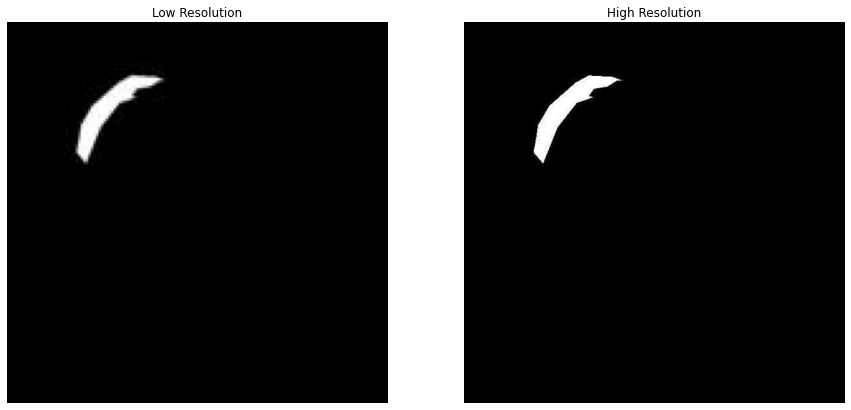

Low resolution Image shape :  (150, 150, 3)
High resolution Image shape:  (600, 600, 3)


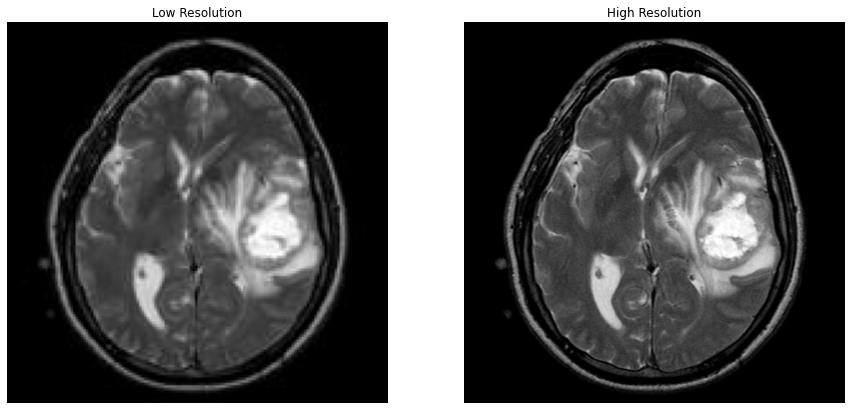

In [23]:
def display(display_list):
    gt_list = ["Low Resolution", "High Resolution"]
    plt.figure(figsize=(15, 15))
    for i in range(len(display_list)):
        plt.subplot(1, len(display_list), i+1)
        plt.title(gt_list[i])
        plt.imshow(display_list[i])
        plt.axis('off')
    plt.show()



for lr, hr in train_ds.take(2):
    print("Low resolution Image shape : ", lr[0].numpy().shape)
    print("High resolution Image shape: ",hr[0].numpy().shape)
    display([lr[0].numpy(), hr[0].numpy()])
    

## Training

### Pre-trained models

If you want to skip training and directly run the demo below, download [weights-srgan.tar.gz](https://martin-krasser.de/sisr/weights-srgan.tar.gz) and extract the archive in the project's root directory. This will create a folder `weights/srgan` containing the weights of the pre-trained models.

### Generator pre-training

In [35]:
pre_trainer = SrganGeneratorTrainer(model=generator(), checkpoint_dir=f'.ckpt/pre_generator')
pre_trainer.train(train_ds,
                  val_ds.take(10),
                  steps=10000, 
                  evaluate_every=1000, 
                  save_best_only=False)

pre_trainer.model.save_weights(weights_file('pre_generator.h5'))

Model restored from checkpoint at step 6000.
7000/10000: loss = 27.568, SSIM = 0.955738, PSNR 38.555183, (283.93s)
8000/10000: loss = 30.883, SSIM = 0.956270, PSNR 36.798450, (281.36s)
9000/10000: loss = 27.326, SSIM = 0.954985, PSNR 36.918880, (281.27s)
10000/10000: loss = 25.754, SSIM = 0.953915, PSNR 36.144684, (281.32s)


## Demo

In [29]:
pre_generator = generator()

pre_generator.load_weights(weights_file('pre_generator.h5'))

In [32]:
from model import resolve_single
from utils import load_image

def resolve_and_plot(lr_image_path):
    lr = load_image(lr_image_path)
    
    pre_sr = resolve_single(pre_generator, lr)
    
    plt.figure(figsize=(20, 20))
    
    images = [lr, pre_sr]
    titles = ['LR', 'SR (PRE)', 'SR (GAN)']
    positions = [1, 3, 4]
    
    for i, (img, title, pos) in enumerate(zip(images, titles, positions)):
        plt.subplot(2, 2, pos)
        plt.imshow(img)
        plt.title(title)
        plt.xticks([])
        plt.yticks([])

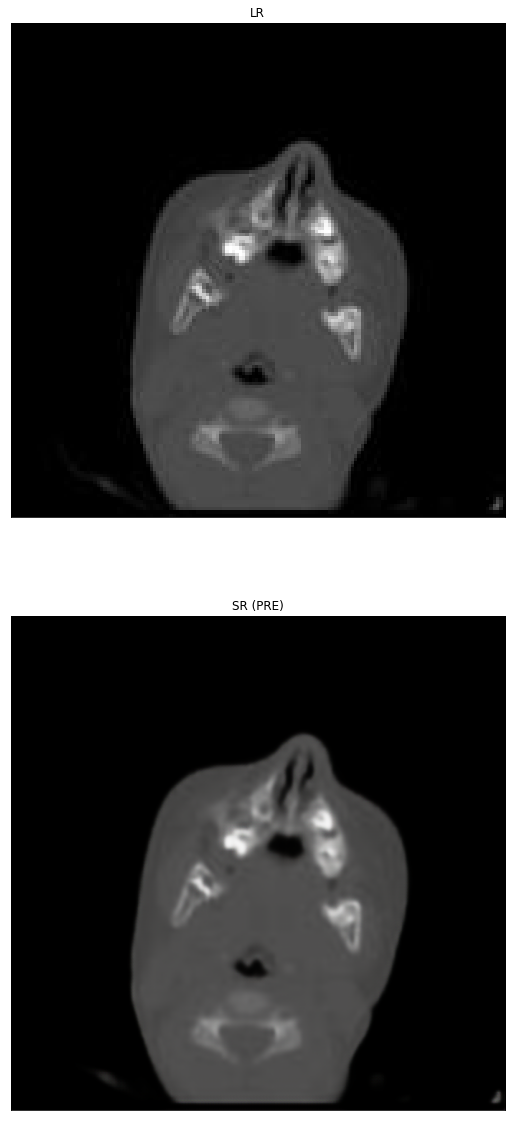

In [34]:
resolve_and_plot('docs/images/testing_image.jpg')